# Deep Leakage From Gradients

https://github.com/mit-han-lab/dlg

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython.display import Image

### provided model architecture:

In [18]:
torch.manual_seed(50)

device = "cpu"

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		act = nn.Sigmoid
		self.body = nn.Sequential(
			nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
			act(),
		)
		self.fc = nn.Sequential(
			nn.Linear(768, 100),
		)
		
	def forward(self, x):
		out = self.body(x)
		out = out.view(out.size(0), -1)
		out = self.fc(out)
		return out

In [19]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [20]:
attacker_net = LeNet().to(device)
attacker_net.apply(weights_init)

criterion = cross_entropy_for_onehot

dummy_data_size=torch.Size([1, 1, 32, 32])

## Shared gradients (Delta W)

In [21]:
forbidden_spell = torch.load('challenge_data/forbidden_spell.pt', map_location=torch.device('cpu'))

print(type(forbidden_spell))

<class 'list'>


Normally, models weights loads as a "state_dict", here we have a list...
Pytorch uses list when dealing with distributed training. cf https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/2

In [22]:
Image(url="https://github.com/mit-han-lab/dlg/blob/master/assets/method.jpg?raw=true")

## Exploit

0 21.3156
10 0.0010
20 0.0000
30 0.0000
40 0.0000
50 0.0000
60 0.0000
70 0.0000
80 0.0000
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000


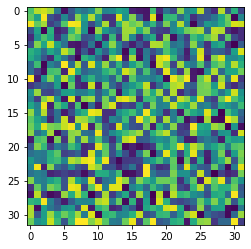

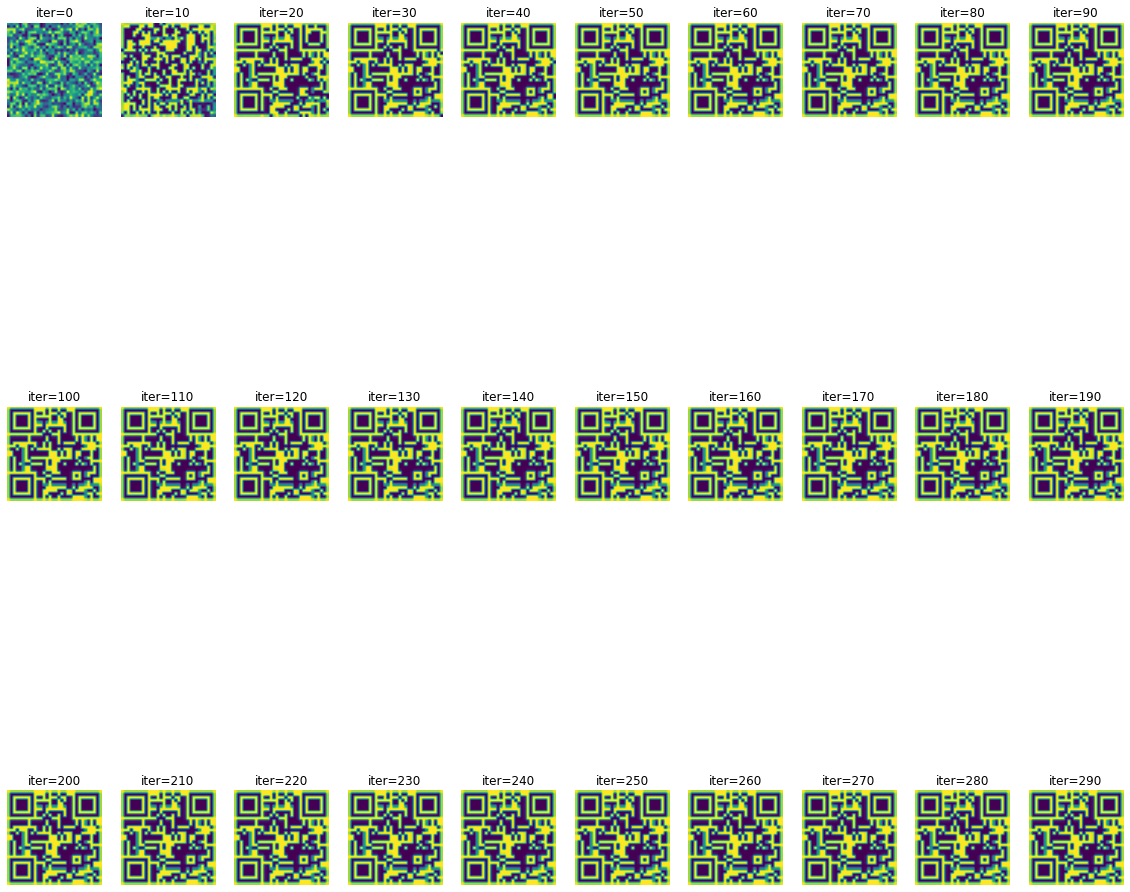

In [23]:
# get gradients
original_dy_dx = list((_.detach().clone() for _ in forbidden_spell))

# generate dummy data and label (gaussian noise)
dummy_data = torch.randn(dummy_data_size).to(device).requires_grad_(True)
dummy_label = torch.randn((1, 100)).to(device).requires_grad_(True)

plt.imshow(transforms.ToPILImage()(dummy_data[0].cpu()))

optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

# train attacker model on obtained gradients
history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

		# dummy inference on attacker with dummy data and labels to produce attacker's gradients
        dummy_pred = attacker_net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
        dummy_dy_dx = torch.autograd.grad(dummy_loss, attacker_net.parameters(), create_graph=True)
        
		# compute gradients difference between provided gradients and attacker model
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
		# retropropagate gradients diff
        grad_diff.backward()
        
        return grad_diff
    
	# operate one training step
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(transforms.ToPILImage()(dummy_data[0].cpu()))

plt.figure(figsize=(20, 20))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')

plt.show()

### Profit !